# **Predicting Stock Price Movements using VIX, Sentiment, and ARIMA-GARCH Predictions**

## **1. Objective**
The goal of this experiment is to predict **extreme stock price movements (drops/surges)** using a combination of:
- **VIX (Volatility Index)**
- **Stock-Specific Sentiment Analysis**
- **Historical Stock Prices**

We aim to develop a **7-day ahead prediction model** that can be used to assess short-term risk in individual S&P 500 stocks.

---

## **2. Data Features & Structure**

### **2.1 Training Dataset (Using Observed VIX Data)**
For each date **t**, we include:
- **VIX Information:**
  - `VIX (t)`: Current VIX value
  - `VIX (t - 7)`: VIX value 7 days ago
  - `VIX (t + 7) (Observed)`: Actual VIX value 7 days in the future (only used in training)

- **Sentiment Data:**
  - `Sentiment Label (t)`: Positive, Neutral, Negative
  - `Sentiment Score (t)`: Scaled score (-1 to +1)

- **Stock Price Data:**
  - `Lagged Price (t - 7)`: Closing price 7 days ago
  - `Percent Change (t - 7 to t)`: Price movement in the last 7 days

- **Target Variable:**
  - `Target (t + 7)`: 1 if the price drops/surges by a defined threshold in 7 days, 0 otherwise


# *ADDED VOLUME NEED TO UPDATE*
| Date (t) | Ticker | VIX (t) | VIX (t - 7) | **VIX (t + 7) (Observed)** | Positive score |  Negative Score | Neutral Score | Highest Sentiment Label | Lagged Price (t - 7) | % Change (t - 7 to t) | Target (t + 7) | 
|----------|--------|---------|------------|---------------------------|------------|-----------|--------|--|-----------------|---------------------|--------------|
| 01/01/22 | AAPL   | 20      | 22         | 25                        | 0.2        | 0.5       | 0.3    | Negative           | $150            | -2%                 | 1 (drop)     |
| 01/01/22 | TSLA   | 20      | 22         | 25                        | 0.5        | 0.3       | 0.2    | Positive       |  $1,000          | +3%                 | 0 (no drop)  |

---

### **2.2 Testing Dataset (Using Predicted VIX from ARIMA-GARCH)**
For future predictions, we **replace observed VIX(t+7) with a predicted value** from the ARIMA-GARCH model.

| Date (t) | Ticker | VIX (t) | VIX (t - 7) | **VIX (t + 7) (Predicted)** | Positive score |  Negative Score | Neutral Score | Highest Sentiment Label | Lagged Price (t - 7) | % Change (t - 7 to t) | Target (t + 7) | 
|----------|--------|---------|------------|---------------------------|------------|-----------|--------|--|-----------------|---------------------|--------------|
| 01/02/25 | AAPL   | 18      | 20         | **23 (Predicted)**        | 0.2        | 0.2       | 0.6    | Neutral           | $150            | -2%                 | 0 (no drop)     |
| 01/02/25 | TSLA   | 22      | 24         | **28 (Predicted)**        | 0.1        | 0.8       | 0.1    | Positive       |  $950          | +3%                 | 1 (drop)  |

---

## **3. Data Splitting Strategy**
To ensure proper model evaluation, we **split the dataset** into:
1. **Training Set (2015 - 2022)**
   - Uses **observed VIX(t+7)** for model learning.
   
2. **Validation Set (2023)**
   - Used for hyperparameter tuning.
   
3. **Testing Set (2024 - 2025)**
   - **Uses precomputed VIX predictions for t+7**, not observed values.
   - This simulates **real-world market conditions**.

---

## **4. Model Workflow**
1. **Train Initial ARIMA-GARCH Model (R)**
   - Fit ARIMA-GARCH using **VIX data from 01/01/2022 - 08/01/2024**.
   - Predict **VIX for 08/08/2024** and store it in **DuckDB**.

2. **Run Rolling Retraining for Future Predictions**
   - Every day, **retrain the model using up-to-date data**.
   - Predict **VIX for t+7**.
   - Store **VIX predictions** in **DuckDB**.

3. **Prepare Data in DuckDB**
   - Store **training and testing datasets** in DuckDB for easy retrieval.
   - Allow the user to set the threshold. Training data **will not** contain target, user must make that.
   
4. **Train a Machine Learning Model**
   - Input: VIX, Sentiment, and Price data.
   - Output: Binary classification (drop/no drop).
   
5. **Evaluate Performance**
   - Compare accuracy using **observed vs. predicted VIX**.

---

## **5. Key Questions for Validation**
- Does **VIX (t-7)** provide additional predictive power?
- How does **sentiment influence stock-specific movements**?
- Does the model perform well when using **predicted VIX instead of observed VIX**?

---

## **6. Next Steps**
- Store **training dataset in DuckDB**.
- Train & test a **classification model (Logistic Regression, XGBoost, or LSTM)**.
- Validate **performance against unseen data**.

---

### **End of Documentation**

In [ ]:
import pandas as pd
import duckdb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
con = duckdb.connect(r"C:/Users/jovan/Documents/CSE 6748 Practicum WITH DATA/financial_news.db", read_only=True)
df = con.execute("SELECT * FROM Headlines.weekly_training_data").fetchdf()
con.close()

In [ ]:
def classify_price_movement(y):
    if y <= -5.0:
        return -2  # Huge Drop
    elif -5.0 < y <= -2.5:
        return -1  # Moderate Drop
    elif -2.5 < y <= -0.5:
        return 0   # minor drop 
    elif -0.5 < y <= 0.5:
        return 1   # No Change
    elif 0.5 < y <= 2.5:
        return 2   # minor increase    
    elif 2.5 <= y < 5.0:
        return 3   # Moderate Surge
    else:
        return 4   # Major Surge

def plot_cm(cm):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_importance(features, X_train):    
    feature_importance_df = pd.DataFrame(
        {"Feature": X_train.columns, "Importance": features}
    ).sort_values(by="Importance", ascending=False)

    # Display top features
    print(feature_importance_df.head(20))  

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df["Feature"].head(20), feature_importance_df["Importance"].head(20))
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Top 20 Most Important Features in XGBoost Model")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
# Sort data by date and ticker before shifting
df = df.sort_values(by=["ticker", "date_t"])

# Shift `price_change_t_7` backwards to create `price_change_t_7_future`
df["price_change_t_7_future"] = df.groupby("ticker")["price_change_t_7"].shift(-1)

# Drop rows where `price_change_t_7_future` is NaN (since we don't have future data for the last row)
df = df.dropna(subset=["price_change_t_7_future"])

df["Target_t_7"] = df["price_change_t_7_future"].apply(classify_price_movement)
df = df.drop(columns=["price_change_t_7_future"])

df["Target_t_7"].value_counts() # honestly this is pretty balanced

In [ ]:
# drop rows that have -1 for price_t, price_t_7_past, volume_t, volume_t_7_past
print(f"Before removing -1s {df.shape}")
filtered_df = df[(df["price_t"] != -1) & (df["price_t_7_past"] != -1) & (df["volume_t"] != -1) & (df["volume_t_7_past"] != -1)]
print(f"After removing -1s {filtered_df.shape}")

# remove everything with subindustry as null 
print(f"Before removing nulls {filtered_df.shape}")
filtered_df = filtered_df[filtered_df["subindustry"].notnull()]
print(f"After removing nulls {filtered_df.shape}")

In [ ]:
filtered_df["Target_t_7"].value_counts() # honestly this is pretty balanced

In [ ]:
# see what rows have NaN values 
filtered_df[filtered_df.isna().any(axis=1)]
# okay looks like we have one weird case where no volume data for BIIB @ 2023-06-12 so its NaN??? lets make it 0 I guess 
filtered_df["volume_change_t_7"] = filtered_df["volume_change_t_7"].fillna(0)
# filtered_df[filtered_df.isna().any(axis=1)]


handle categorical

In [ ]:
categorical_features = ["ticker", "subindustry"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats = encoder.fit_transform(filtered_df[categorical_features])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

In [ ]:
processed_df = filtered_df.drop(columns=categorical_features)
processed_df = processed_df.drop(columns=["guid", "sentiment_label_t"])
# processed_df = pd.concat([processed_df, encoded_df], axis=1)
processed_df.columns

In [ ]:
scaler = StandardScaler()

date_col = processed_df["date_t"].reset_index(drop=True)  # Reset index
target_col = processed_df["Target_t_7"].reset_index(drop=True)  # Reset index
processed_df_no_date = processed_df.drop(columns=["date_t", "Target_t_7"]).reset_index(drop=True)

scaled_features = scaler.fit_transform(processed_df_no_date)
scaled_df = pd.DataFrame(scaled_features, columns=processed_df_no_date.columns)
print(scaled_df[scaled_df.isna().any(axis=1)].size)
if date_col.index.equals(scaled_df.index) and target_col.index.equals(scaled_df.index):
    scaled_df = pd.concat([date_col, scaled_df, target_col], axis=1)    
    print(scaled_df.columns)
else:
    raise ValueError("Index mismatch")

In [ ]:
final_df = pd.concat([scaled_df, encoded_df], axis=1)
final_df.head()

In [ ]:
# find unique dates 
final_df = final_df.sort_values(by="date_t", ascending=True)
dates = final_df["date_t"].unique()
print(len(dates) * 0.8)
print(dates[108])

# so the middle is at index 108 
train_dates = dates[:108]
test_dates = dates[108:]

train_df = final_df[final_df["date_t"].isin(train_dates)]
test_df = final_df[final_df["date_t"].isin(test_dates)]

X_train = train_df.drop(columns=["Target_t_7", "date_t"])
y_train = train_df["Target_t_7"]

X_test = test_df.drop(columns=["Target_t_7", "date_t"])
y_test = test_df["Target_t_7"]

In [42]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.19      0.23      0.21       330
          -1       0.08      0.03      0.05       950
           0       0.26      0.06      0.10      6196
           1       0.38      0.49      0.43      8259
           2       0.35      0.32      0.34      7408
           3       0.08      0.16      0.10      1273
           4       0.09      0.45      0.15       482

    accuracy                           0.29     24898
   macro avg       0.20      0.25      0.20     24898
weighted avg       0.31      0.29      0.28     24898



[[  75   12   30   63   15   49   86]
 [  28   33   68  308  221  113  179]
 [  64  121  394 2898 1564  624  531]
 [  61   66  443 4011 2353  716  609]
 [  65  126  459 2957 2407  805  589]
 [  32   24   75  310  336  199  297]
 [  74   18   28   19   50   76  217]]


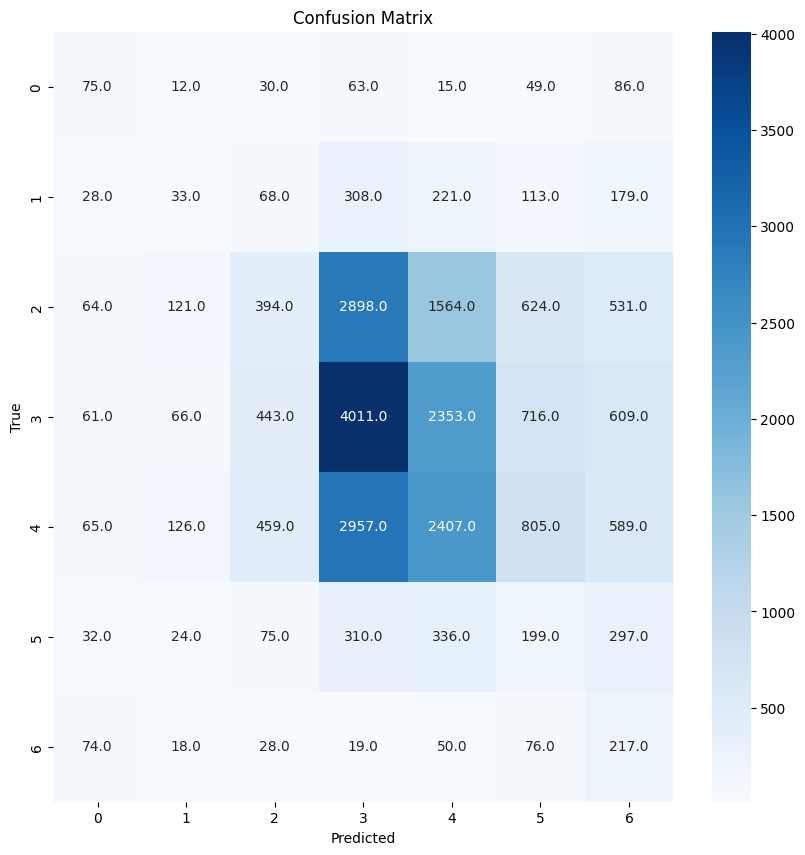

In [43]:
# confusion matrix
print(confusion_matrix(y_test, y_pred))
plot_cm(confusion_matrix(y_test, y_pred))

In [44]:

y_train_fixed = y_train + 2
y_test_fixed = y_test + 2

classes = np.unique(y_train_fixed)
print(f"Classes: {classes}")
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_fixed)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print(f"Class weights: {class_weight_dict}")

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=7,
    eval_metric="mlogloss",  # Multi-class log loss
    scale_pos_weight=class_weights,  # Handles class imbalance
    seed=42
)

# Train the model
xgb_model.fit(X_train, y_train_fixed)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
print(classification_report(y_test_fixed, y_pred_xgb))

Classes: [0 1 2 3 4 5 6]
Class weights: {np.int64(0): np.float64(9.946262028127313), np.int64(1): np.float64(2.8023774765380605), np.int64(2): np.float64(0.6427471276463441), np.int64(3): np.float64(0.37483960232534785), np.int64(4): np.float64(0.5332301587301588), np.int64(5): np.float64(2.691571188206073), np.int64(6): np.float64(13.870148637489677)}


c:\Users\jovan\anaconda3\envs\cs7643-a2\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.87      0.52      0.65       330
           1       0.67      0.20      0.30       950
           2       0.56      0.22      0.32      6196
           3       0.41      0.69      0.51      8259
           4       0.48      0.46      0.47      7408
           5       0.72      0.40      0.51      1273
           6       0.83      0.36      0.50       482

    accuracy                           0.46     24898
   macro avg       0.65      0.41      0.47     24898
weighted avg       0.51      0.46      0.44     24898



[[ 173   15   10  103   15    4   10]
 [   2  186   80  481  184   15    2]
 [   3   14 1362 3481 1273   58    5]
 [   6   20  551 5719 1889   65    9]
 [  12   33  344 3586 3377   48    8]
 [   3    6   56  510  193  503    2]
 [   0    3   26  214   61    6  172]]


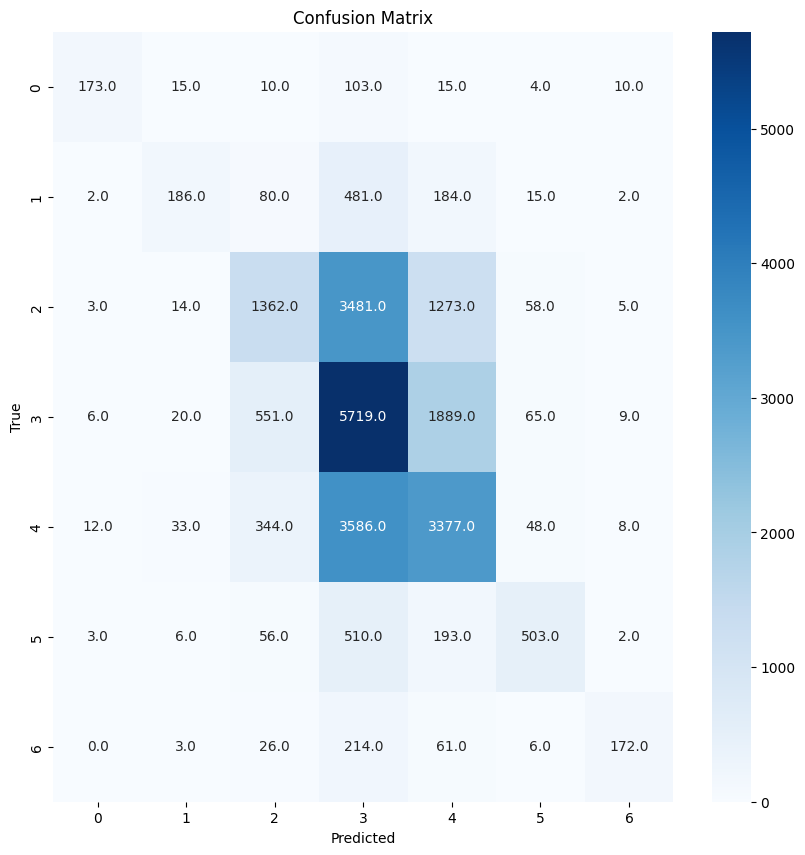

In [45]:
print(confusion_matrix(y_test_fixed, y_pred_xgb))
plot_cm(confusion_matrix(y_test_fixed, y_pred_xgb))

                  Feature  Importance
9    sentiment_positive_t    0.011535
2          vix_t_7_future    0.011108
0                   vix_t    0.010158
1            vix_t_7_past    0.009077
410            ticker_NOC    0.005240
423           ticker_NXPI    0.005009
648  subindustry_20202030    0.004985
605            ticker_XOM    0.004683
396            ticker_MTB    0.004648
11   sentiment_negative_t    0.004452
746  subindustry_60106010    0.004449
739  subindustry_55103010    0.004379
112            ticker_CCK    0.004302
660  subindustry_25201030    0.004284
617  subindustry_10102020    0.004199
726  subindustry_45301020    0.004109
737  subindustry_55101010    0.004030
343             ticker_LH    0.004006
717  subindustry_45103010    0.003963
687  subindustry_30202030    0.003857


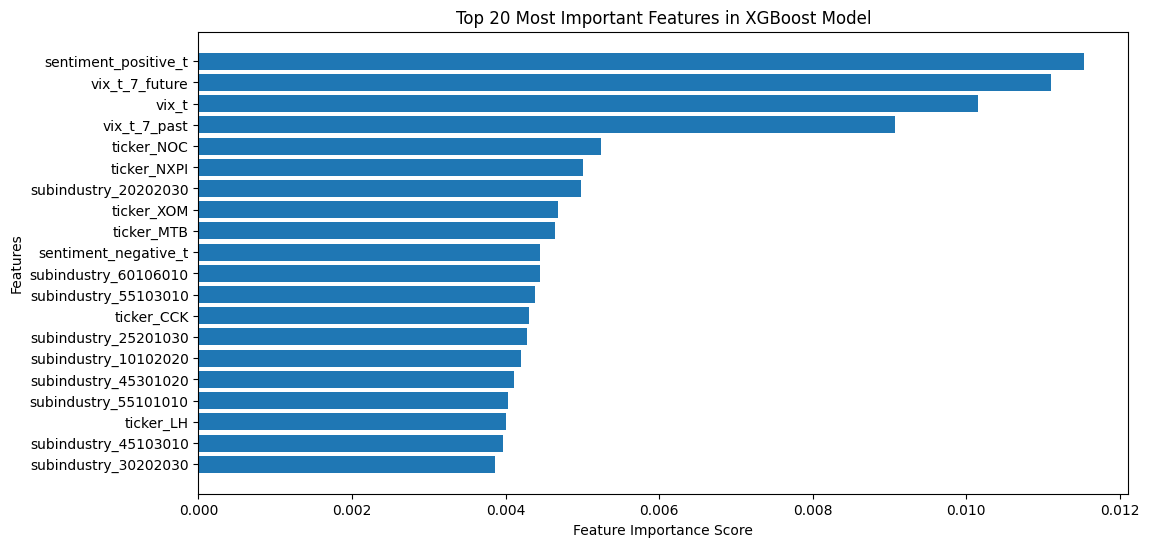

In [46]:
plot_feature_importance(xgb_model.feature_importances_, X_train)

weird okay so both the models did great with training data

are we overfitting? did we memorize?

# TEST

In [47]:
# okay lets load Headlines.weekly_test_data, take it through the same process and see how it does
con = duckdb.connect(r"C:/Users/jovan/Documents/CSE 6748 Practicum WITH DATA/financial_news.db", read_only=True)
df = con.execute("SELECT * FROM Headlines.weekly_test_data").fetchdf()
con.close()

df = df.sort_values(by=["ticker", "date_t"])

# Shift `price_change_t_7` backwards to create `price_change_t_7_future`
df["price_change_t_7_future"] = df.groupby("ticker")["price_change_t_7"].shift(-1)

# Drop rows where `price_change_t_7_future` is NaN (since we don't have future data for the last row)
df = df.dropna(subset=["price_change_t_7_future"])

df["Target_t_7"] = df["price_change_t_7_future"].apply(classify_price_movement)
df = df.drop(columns=["price_change_t_7_future"])

df["Target_t_7"].value_counts() # honestly this is pretty balanced

Target_t_7
 1    12542
 2    11431
 0    10757
-1     2876
 3     2557
 4      949
-2      748
Name: count, dtype: int64

In [48]:
df.head()

,guid,date_t,ticker,subindustry,vix_t,vix_t_7_past,vix_t_7_future,price_t,price_t_7_past,price_change_t_7,volume_t,volume_t_7_past,volume_change_t_7,sentiment_label_t,sentiment_positive_t,sentiment_neutral_t,sentiment_negative_t,Target_t_7
780,fca0839a-68c5-3aaa-9b24-d4dd12306c93,2024-07-29,A,35203010,23.389999,16.389999,23.739477,137.380005,137.320007,0.043692,1222648,1717670,-28.819389,NEGATIVE,1.457781e-05,7.479962e-06,9.999779e-01,-1
3678,None,2024-08-05,A,35203010,20.370001,23.389999,19.445204,134.699997,139.039993,-3.121401,1885243,2298354,-17.974211,NEUTRAL,0.000000e+00,1.000000e+00,0.000000e+00,0
3937,d65967d8-0017-3051-9eb7-6c1f8eca1762,2024-08-12,A,35203010,14.800000,20.370001,15.545537,135.600006,136.899994,-0.949589,1347171,737614,82.639023,POSITIVE,9.977054e-01,5.356342e-07,2.294097e-03,1
5793,466b01e6-880b-3d20-ac96-bd7c22f4916b,2024-08-19,A,35203010,15.860000,14.800000,16.301971,140.509995,140.039993,0.335619,1714023,1284834,33.404237,NEUTRAL,4.793020e-09,1.000000e+00,3.514156e-08,1
7681,a6ffa3a3-8ead-3394-bdbb-6523304b0ae9,2024-08-26,A,35203010,15.000000,15.860000,15.120406,140.490005,140.869995,-0.269745,1013194,1735574,-41.621965,NEGATIVE,2.634196e-04,3.272604e-01,6.724762e-01,1


In [49]:
test_df = df
test_df["volume_change_t_7"] = df["volume_change_t_7"].fillna(0)
categorical_features = ["ticker", "subindustry"]

In [50]:
encoded_cats = encoder.transform(test_df[categorical_features])  # Use trained encoder
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))
test_df = test_df.drop(columns=categorical_features)
test_df = test_df.drop(columns=["guid", "sentiment_label_t"])
date_col = test_df["date_t"].reset_index(drop=True)  # Reset index
target_col = test_df["Target_t_7"].reset_index(drop=True)  # Reset index
test_df_no_date = test_df.drop(columns=["date_t", "Target_t_7"]).reset_index(drop=True)
test_df_no_date.columns

Index(['vix_t', 'vix_t_7_past', 'vix_t_7_future', 'price_t', 'price_t_7_past',
       'price_change_t_7', 'volume_t', 'volume_t_7_past', 'volume_change_t_7',
       'sentiment_positive_t', 'sentiment_neutral_t', 'sentiment_negative_t'],
      dtype='object')

In [51]:
scaled_features = scaler.transform(test_df_no_date)  # Use trained scaler
scaled_df = pd.DataFrame(scaled_features, columns=test_df_no_date.columns)

date_col = test_df["date_t"].reset_index(drop=True)
final_test_df = pd.concat([date_col,target_col, scaled_df, encoded_df], axis=1)
final_test_df.head()

,date_t,Target_t_7,vix_t,vix_t_7_past,vix_t_7_future,price_t,price_t_7_past,price_change_t_7,volume_t,volume_t_7_past,...,subindustry_60105010,subindustry_60106010,subindustry_60106020,subindustry_60107010,subindustry_60108010,subindustry_60108020,subindustry_60108030,subindustry_60108040,subindustry_60108050,subindustry_60201040
0,2024-07-29,-1,0.801450,-0.394006,0.855452,-0.072800,-0.072689,-0.014099,-0.199094,-0.184431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-05,0,0.285549,0.801398,0.121612,-0.081663,-0.066996,-1.484456,-0.182053,-0.171299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-12,1,-0.665964,0.285667,-0.544794,-0.078687,-0.074079,-0.475532,-0.195891,-0.206595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-19,1,-0.484886,-0.665533,-0.415528,-0.062448,-0.063686,0.121517,-0.186456,-0.194220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-26,1,-0.631799,-0.484515,-0.617443,-0.062514,-0.060939,-0.159708,-0.204481,-0.184026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# fill nans for 0 for now. don't feel liek fixing it 
final_test_df = final_test_df.fillna(0)

In [53]:
X_test_new = final_test_df.drop(columns=["Target_t_7", "date_t"])
y_test_new = final_test_df["Target_t_7"]

y_pred_new = model.predict(X_test_new)

In [54]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

          -2       0.11      0.11      0.11       748
          -1       0.06      0.01      0.02      2876
           0       0.26      0.09      0.14     10757
           1       0.33      0.45      0.38     12542
           2       0.29      0.28      0.28     11431
           3       0.06      0.13      0.08      2557
           4       0.09      0.25      0.13       949

    accuracy                           0.25     41860
   macro avg       0.17      0.19      0.16     41860
weighted avg       0.26      0.25      0.24     41860



[[  85   32   60  236  114  127   94]
 [ 118   43  303  835  600  672  305]
 [ 217  159 1007 4687 2731 1432  524]
 [ 110  191 1091 5694 3413 1457  586]
 [ 127  196 1046 4835 3184 1427  616]
 [  79   25  228  936  671  321  297]
 [  20   40  147  188  252   63  239]]


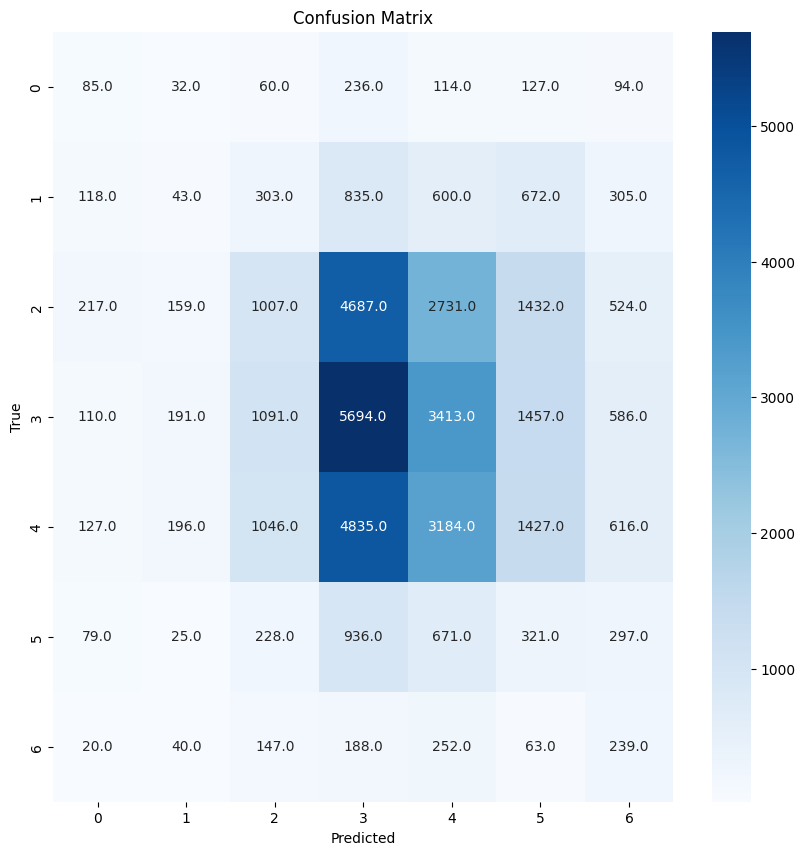

In [55]:
print(confusion_matrix(y_test_new, y_pred_new))
plot_cm(confusion_matrix(y_test_new, y_pred_new))

In [56]:
# now for xgboost
y_test_new_fixed = y_test_new + 2
y_pred_xgb_new = xgb_model.predict(X_test_new)

print(classification_report(y_test_new_fixed, y_pred_xgb_new))

              precision    recall  f1-score   support

           0       0.78      0.32      0.46       748
           1       0.49      0.08      0.14      2876
           2       0.36      0.28      0.31     10757
           3       0.36      0.60      0.45     12542
           4       0.38      0.36      0.37     11431
           5       0.67      0.22      0.33      2557
           6       0.83      0.29      0.43       949

    accuracy                           0.38     41860
   macro avg       0.55      0.31      0.36     41860
weighted avg       0.41      0.38      0.36     41860



[[ 243   26  127  251   86    8    7]
 [  10  233  842 1278  466   37   10]
 [  17   44 2994 5009 2597   86   10]
 [  12   64 1885 7546 2969   62    4]
 [  13   72 1844 5304 4111   74   13]
 [  10   20  501  910  548  556   12]
 [   7   14  164  376  110    5  273]]


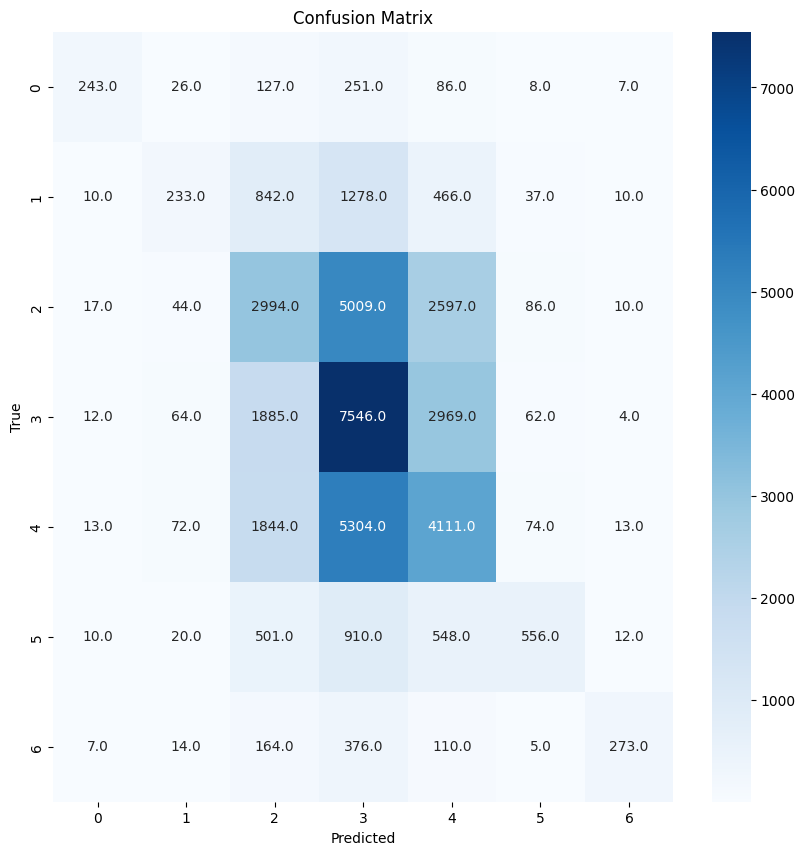

In [57]:
cm = confusion_matrix(y_test_new_fixed, y_pred_xgb_new)
print(cm)
plot_cm(cm)

                  Feature  Importance
9    sentiment_positive_t    0.011535
2          vix_t_7_future    0.011108
0                   vix_t    0.010158
1            vix_t_7_past    0.009077
410            ticker_NOC    0.005240
423           ticker_NXPI    0.005009
648  subindustry_20202030    0.004985
605            ticker_XOM    0.004683
396            ticker_MTB    0.004648
11   sentiment_negative_t    0.004452
746  subindustry_60106010    0.004449
739  subindustry_55103010    0.004379
112            ticker_CCK    0.004302
660  subindustry_25201030    0.004284
617  subindustry_10102020    0.004199
726  subindustry_45301020    0.004109
737  subindustry_55101010    0.004030
343             ticker_LH    0.004006
717  subindustry_45103010    0.003963
687  subindustry_30202030    0.003857


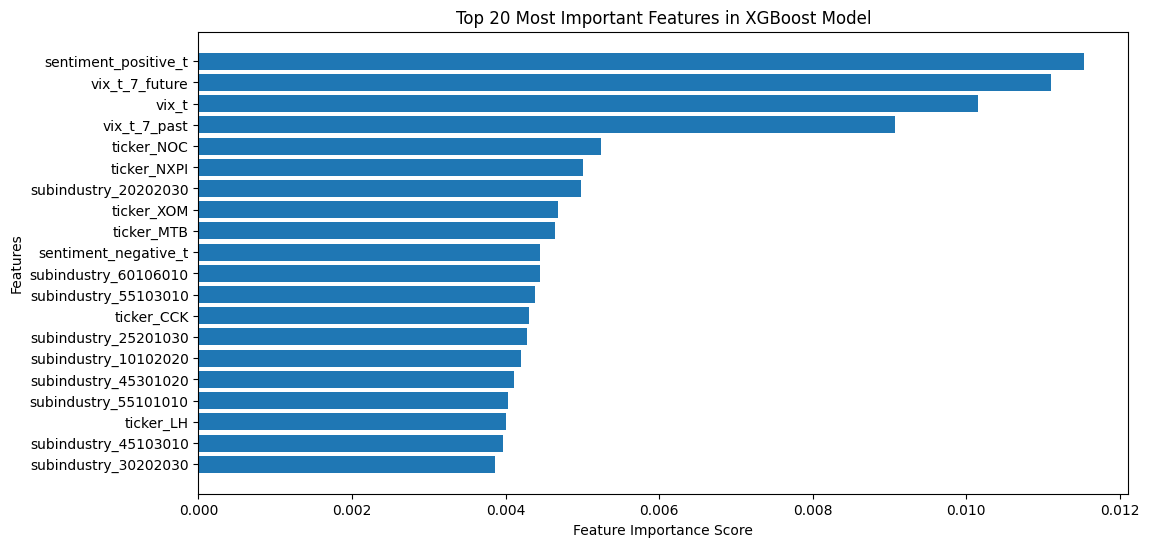

In [58]:

# Get feature importance scores from trained XGBoost model
feature_importance = xgb_model.feature_importances_
plot_feature_importance(feature_importance, X_test_new)